## Import necessary libraries

In [ ]:
%matplotlib inline

In [13]:
import matplotlib.pyplot as plt
import matplotlib
import ndreg
from ndreg import preprocessor, util, plotter
import SimpleITK as sitk

In [14]:
import numpy as np

In [15]:
import ndreg.vis as vis

In [16]:
import tensorflow as tf

In [41]:
from tqdm import tqdm_notebook,tqdm

In [17]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [18]:
def myshow(img, cmap='gray', colorbar=False):
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=cmap)
    if colorbar: plt.colorbar()
    plt.axis('off')
    plt.show()

### Some metadata is required before registration

In [33]:
params = {
    # input image path
    'image_path': './data/Thy1eYFP_Control_9.tiff',
    # voxel spacing is in mm and corresponds to (x, y, z) spacing
    'image_spacing': (0.04128, 0.04128, 0.04128),
    'image_orientation': 'rpi',
    # the modality can be 'lavision' or 'colm'
    'image_modality': 'lavision',
    'atlas_spacing': (0.05, 0.05, 0.05),
    'atlas_path': './data/ARA_50um.tiff',
}

## Load the sample data

In [34]:
img = util.imgRead(params['image_path'])
img.SetSpacing(params['image_spacing'])
atlas = util.imgRead(params['atlas_path'])
atlas.SetSpacing(params['atlas_spacing'])

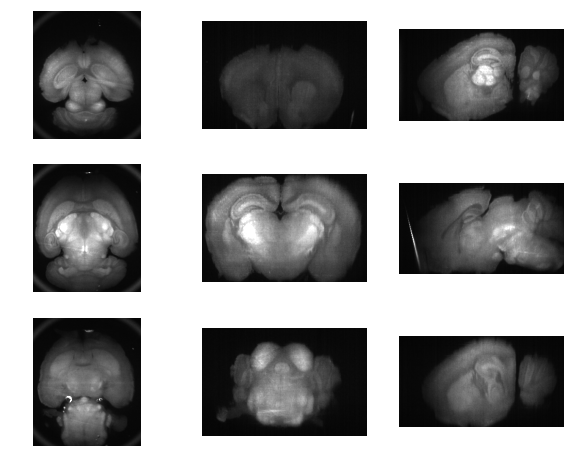

In [21]:
plotter.imgShow(img, vmax=2000)

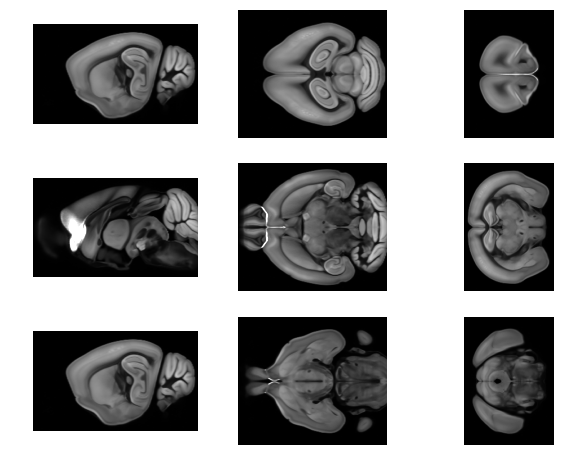

In [22]:
plotter.imgShow(atlas, vmax=400)

## Preprocessing
This step preprocesses the input CLARITY images by resampling them to match the resolution of the atlas, bias correcting the images, and normalizing them by subtracting the mean and dividing by the standard deviation of the image intensities.

In [ ]:
img_p = preprocessor.preprocess_brain(img, 
                                      [0.20]*3, 
                                      params['image_modality'],
                                      params['image_orientation'])

In [ ]:
atlas = preprocessor.imgResample(atlas,[0.20]*3)

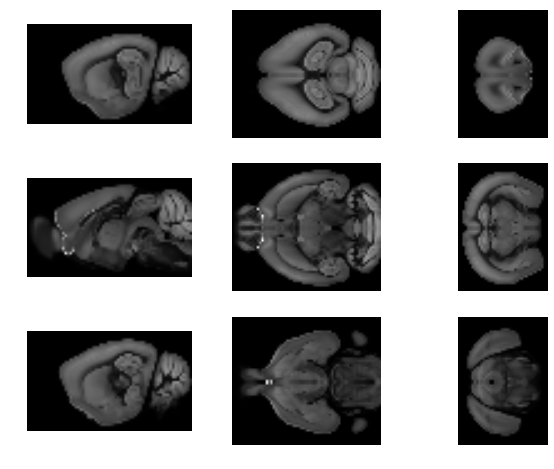

In [25]:
plotter.imgShow(atlas)

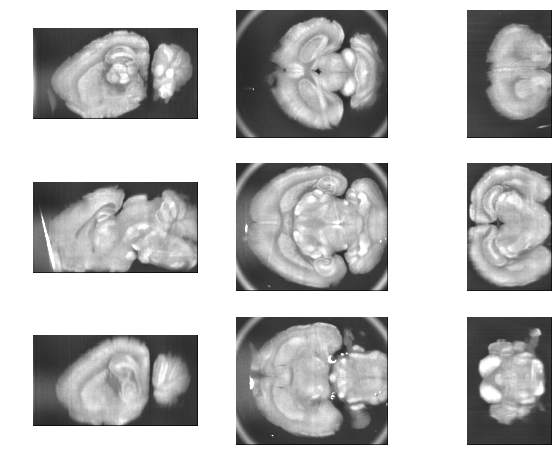

In [26]:
plotter.imgShow(img_p,vmax=2)

In [27]:
I = sitk.GetArrayFromImage(atlas)
J = sitk.GetArrayFromImage(img)
nxI = list(I.shape)
dxI = np.array(atlas.GetSpacing())[::-1]
nxJ = list(J.shape)
dxJ = np.array(img.GetSpacing())[::-1]
xI = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxI,dxI)]
xJ = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxJ,dxJ)]

# I would like to pad one slice of the allen atlas so that it has zero boundary conditions
zeroslice = np.zeros((nxI[0],1,nxI[2]))
I = np.concatenate((I,zeroslice),axis=1)
nxI[1] += 1
xI = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxI,dxI)]


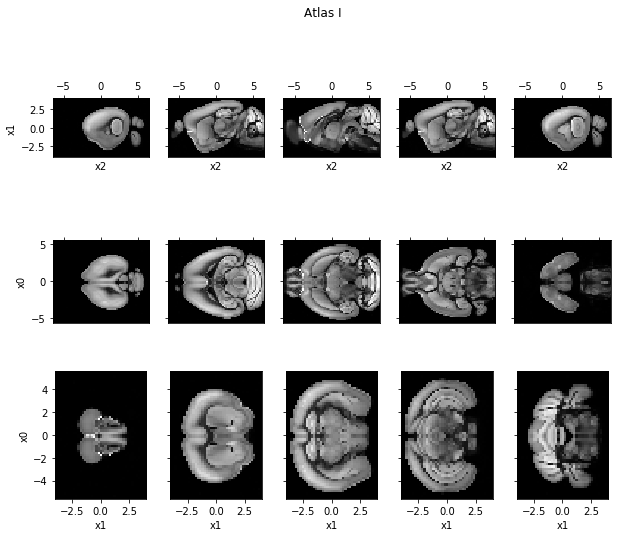

In [28]:
# display the data
f = plt.figure()
vis.imshow_slices(I, x=xI, fig=f)
f.suptitle('Atlas I')
f.canvas.draw()

The output of this method is the atlas registered to the raw data

Updating weights
Finished iteration 0, energy 2.875971e+02 (match 2.875971e+02, reg 0.000000e+00)
Updating weights
Finished iteration 1, energy 2.128269e+02 (match 2.128269e+02, reg 0.000000e+00)
Updating weights
Finished iteration 2, energy 2.001240e+02 (match 2.001240e+02, reg 0.000000e+00)
Updating weights
Finished iteration 3, energy 1.903626e+02 (match 1.903626e+02, reg 0.000000e+00)
Updating weights
Finished iteration 4, energy 1.838107e+02 (match 1.838107e+02, reg 0.000000e+00)
Updating weights
Finished iteration 5, energy 1.793349e+02 (match 1.793349e+02, reg 0.000000e+00)
Finished iteration 6, energy 1.788161e+02 (match 1.788156e+02, reg 4.616462e-04)
Finished iteration 7, energy 1.782563e+02 (match 1.782544e+02, reg 1.813728e-03)
Finished iteration 8, energy 1.777285e+02 (match 1.777245e+02, reg 3.994701e-03)
Finished iteration 9, energy 1.772404e+02 (match 1.772334e+02, reg 6.946237e-03)
CPU times: user 3min 20s, sys: 31.4 s, total: 3min 52s
Wall time: 1min 8s


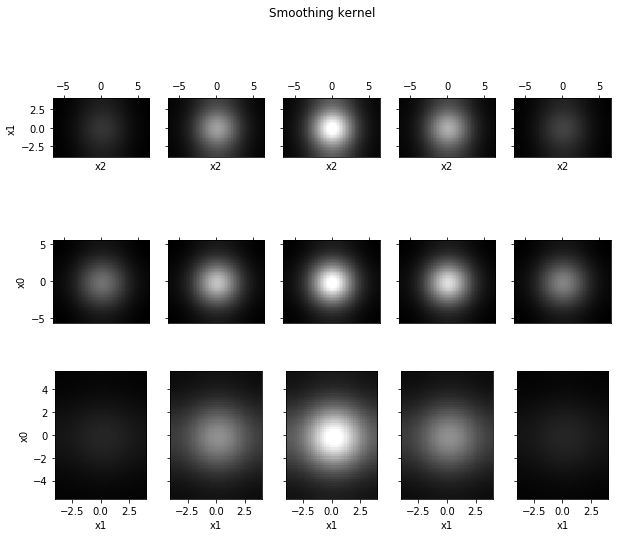

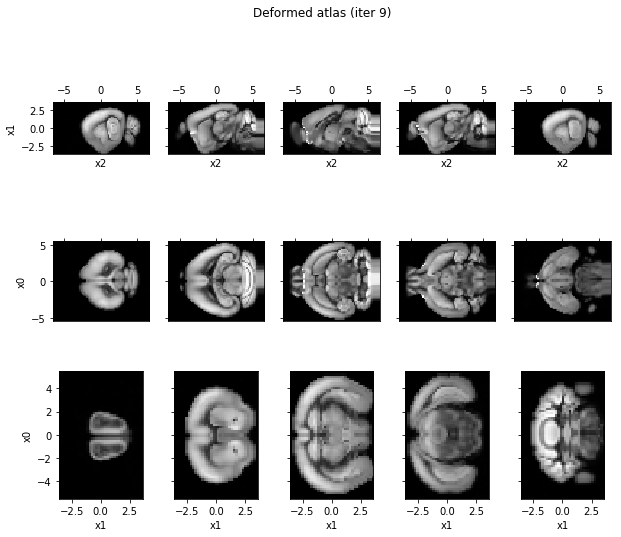

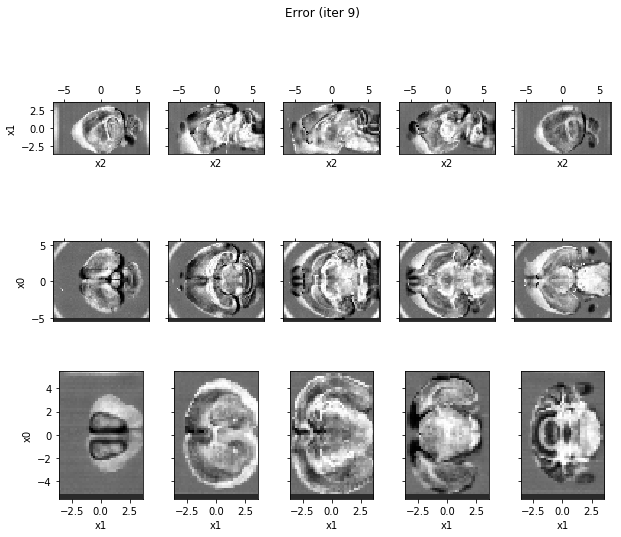

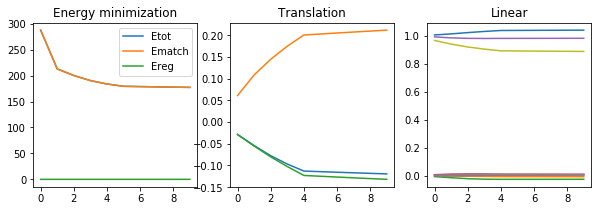

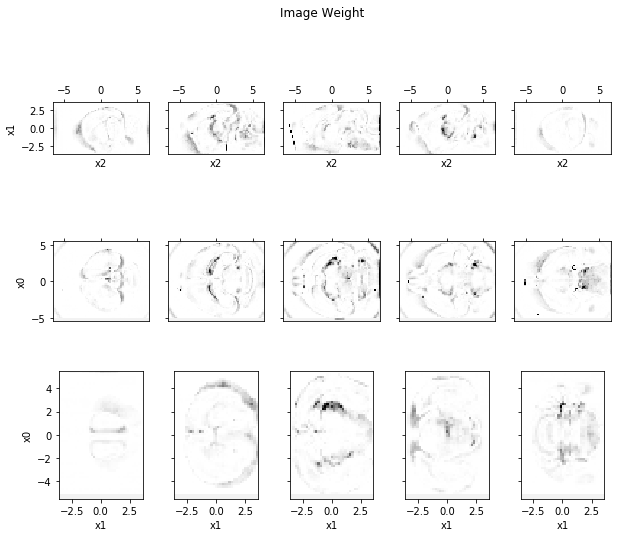

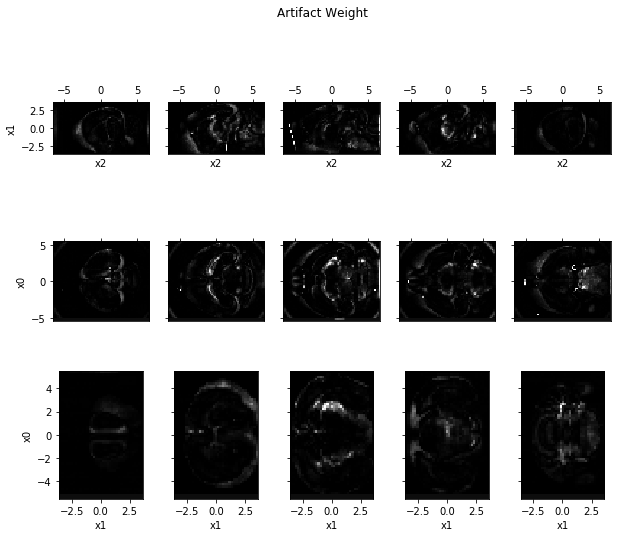

In [32]:
%%time
atlas_registered, out = ndreg.register_brain(atlas, img_p)

In [117]:
from ndreg import lddmm
def get_grid_locations(image,spacing):
    x = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(list(image.shape),spacing)]
#     x_meshgrid = np.meshgrid(x[0],x[1],x[2],indexing='ij')
    return x
    
def resample(image,image_meshgrid,transformation):
#     grid_locations = get_meshgrid(image,spacing)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        image_r = lddmm.interp3(image_meshgrid[0],image_meshgrid[1],image_meshgrid[2],
                                image,
                                transformation[0],transformation[1],transformation[2])
        image_rnp = image_r.eval()
    return image_rnp

In [39]:
resolutions = [0.25,.5,.75,1.]
spacings = [np.array(params['atlas_spacing'])/i for i in resolutions]

0it [00:00, ?it/s]

Updating weights
Finished iteration 0, energy 2.875147e+02 (match 2.875147e+02, reg 0.000000e+00)
Updating weights
Finished iteration 1, energy 2.127738e+02 (match 2.127738e+02, reg 0.000000e+00)
Updating weights
Finished iteration 2, energy 2.000680e+02 (match 2.000680e+02, reg 0.000000e+00)
Updating weights
Finished iteration 3, energy 1.903139e+02 (match 1.903139e+02, reg 0.000000e+00)
Updating weights
Finished iteration 4, energy 1.837702e+02 (match 1.837702e+02, reg 0.000000e+00)
Updating weights
Finished iteration 5, energy 1.792902e+02 (match 1.792902e+02, reg 0.000000e+00)
Finished iteration 6, energy 1.787713e+02 (match 1.787708e+02, reg 4.619258e-04)
Finished iteration 7, energy 1.782112e+02 (match 1.782094e+02, reg 1.814815e-03)
Finished iteration 8, energy 1.776835e+02 (match 1.776795e+02, reg 3.997118e-03)
Finished iteration 9, energy 1.771958e+02 (match 1.771888e+02, reg 6.950501e-03)


1it [01:11, 71.65s/it]

Updating weights
Finished iteration 0, energy 3.631052e+01 (match 3.631052e+01, reg 0.000000e+00)
Updating weights
Finished iteration 1, energy 2.940014e+01 (match 2.940014e+01, reg 0.000000e+00)
Updating weights
Finished iteration 2, energy 2.896235e+01 (match 2.896235e+01, reg 0.000000e+00)
Updating weights
Finished iteration 3, energy 2.855413e+01 (match 2.855413e+01, reg 0.000000e+00)
Updating weights
Finished iteration 4, energy 2.820429e+01 (match 2.820429e+01, reg 0.000000e+00)
Updating weights
Finished iteration 5, energy 2.794179e+01 (match 2.794179e+01, reg 0.000000e+00)
Finished iteration 6, energy 2.786023e+01 (match 2.785719e+01, reg 3.042479e-03)
Finished iteration 7, energy 2.777563e+01 (match 2.776364e+01, reg 1.199590e-02)
Finished iteration 8, energy 2.769930e+01 (match 2.767275e+01, reg 2.654597e-02)
Finished iteration 9, energy 2.763064e+01 (match 2.758424e+01, reg 4.639300e-02)


2it [03:27, 90.91s/it]

Updating weights
Finished iteration 0, energy 1.077292e+01 (match 1.077292e+01, reg 0.000000e+00)
Updating weights
Finished iteration 1, energy 8.809589e+00 (match 8.809589e+00, reg 0.000000e+00)
Updating weights
Finished iteration 2, energy 8.734315e+00 (match 8.734315e+00, reg 0.000000e+00)
Updating weights
Finished iteration 3, energy 8.705090e+00 (match 8.705090e+00, reg 0.000000e+00)
Updating weights
Finished iteration 4, energy 8.680382e+00 (match 8.680382e+00, reg 0.000000e+00)
Updating weights
Finished iteration 5, energy 8.647176e+00 (match 8.647176e+00, reg 0.000000e+00)
Finished iteration 6, energy 8.607566e+00 (match 8.601965e+00, reg 5.601095e-03)
Finished iteration 7, energy 8.575097e+00 (match 8.552974e+00, reg 2.212314e-02)
Finished iteration 8, energy 8.554999e+00 (match 8.506009e+00, reg 4.899005e-02)
Finished iteration 9, energy 8.546781e+00 (match 8.461133e+00, reg 8.564798e-02)


3it [08:01, 145.73s/it]/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Updating weights
Finished iteration 0, energy 4.564863e+00 (match 4.564863e+00, reg 0.000000e+00)
Updating weights
Finished iteration 1, energy 3.742390e+00 (match 3.742390e+00, reg 0.000000e+00)
Updating weights
Finished iteration 2, energy 3.716256e+00 (match 3.716256e+00, reg 0.000000e+00)
Updating weights
Finished iteration 3, energy 3.709153e+00 (match 3.709153e+00, reg 0.000000e+00)
Updating weights
Finished iteration 4, energy 3.703899e+00 (match 3.703899e+00, reg 0.000000e+00)
Updating weights
Finished iteration 5, energy 3.699055e+00 (match 3.699055e+00, reg 0.000000e+00)
Finished iteration 6, energy 3.683104e+00 (match 3.674904e+00, reg 8.200215e-03)
Finished iteration 7, energy 3.681053e+00 (match 3.648695e+00, reg 3.235809e-02)
Finished iteration 8, energy 3.695592e+00 (match 3.624082e+00, reg 7.150972e-02)
Finished iteration 9, energy 3.725440e+00 (match 3.600700e+00, reg 1.247404e-01)


4it [20:41, 329.99s/it]


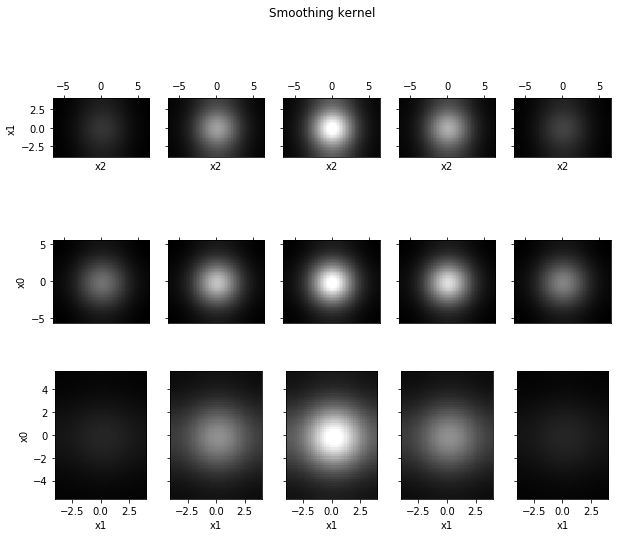

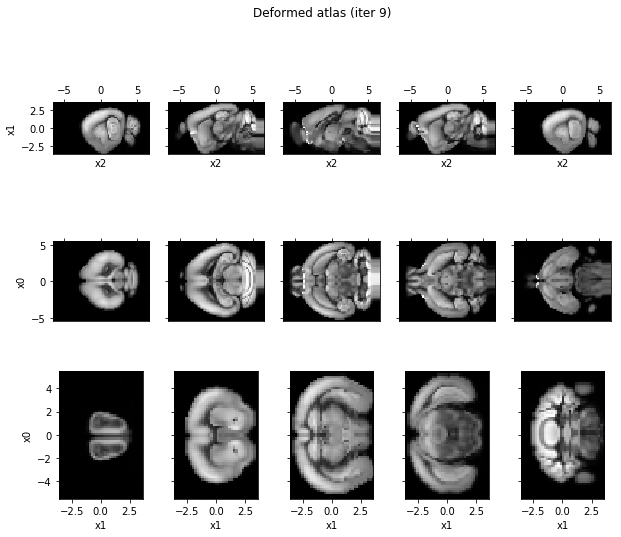

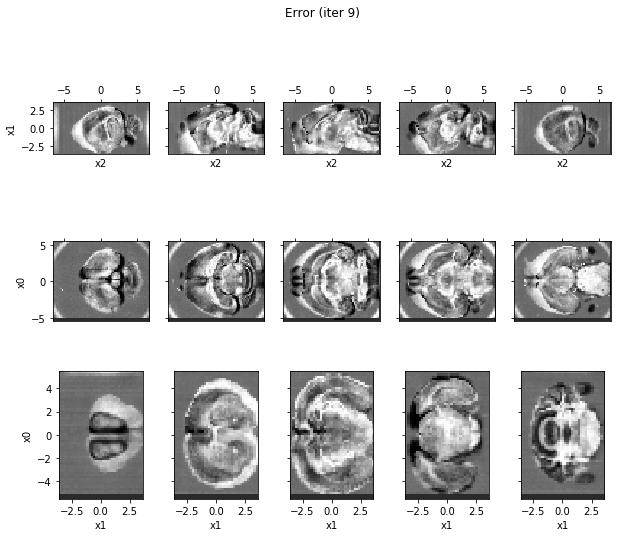

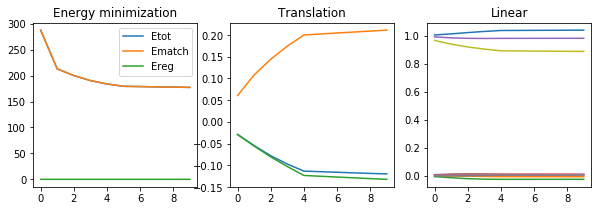

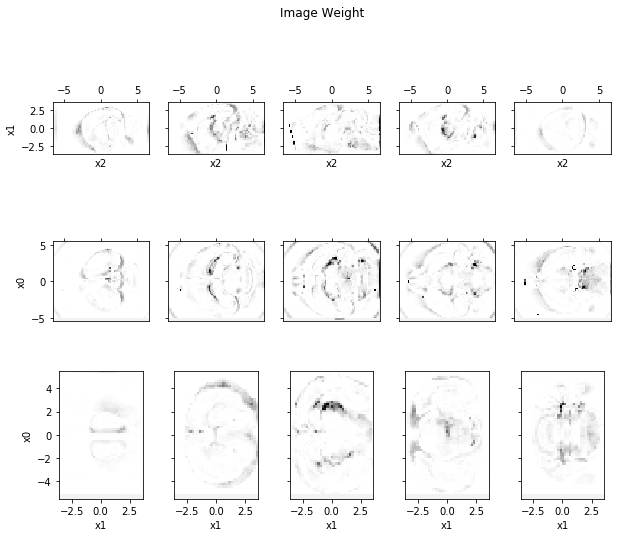

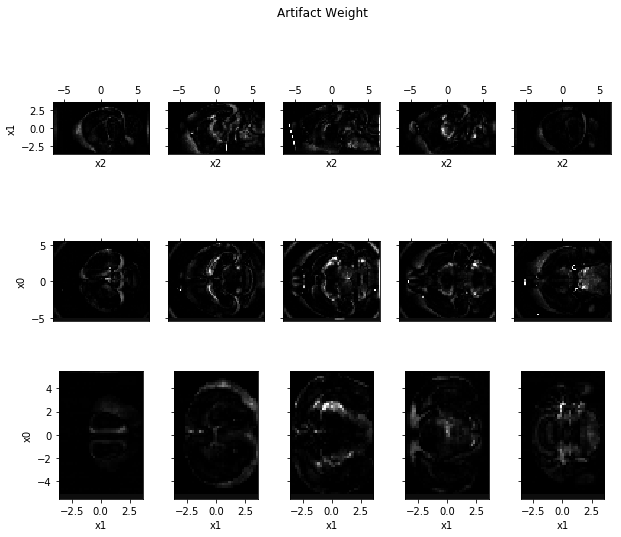

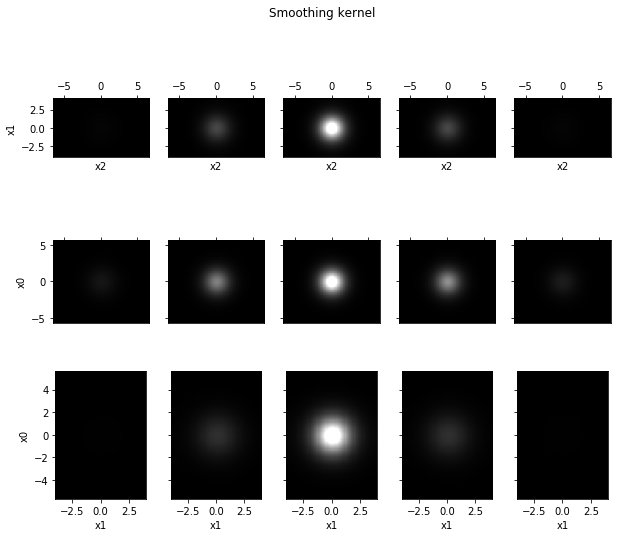

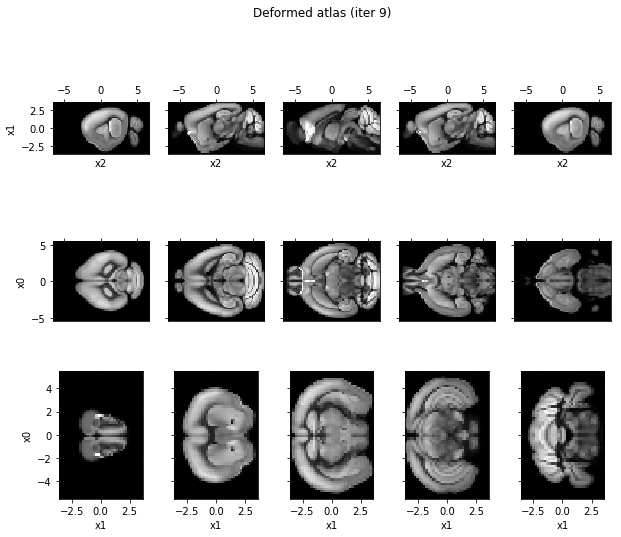

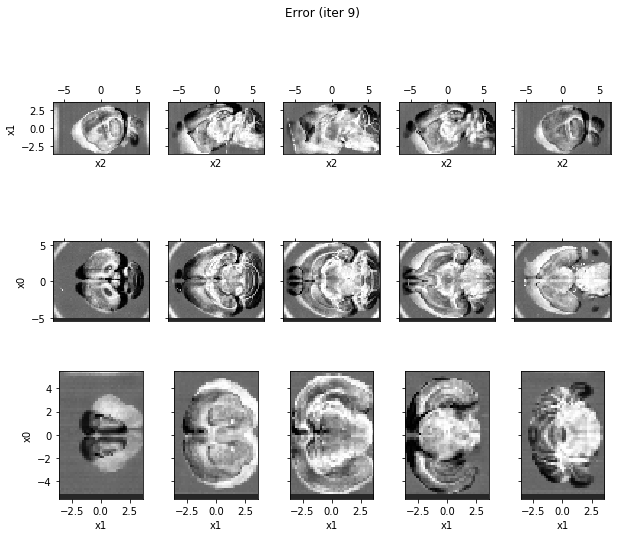

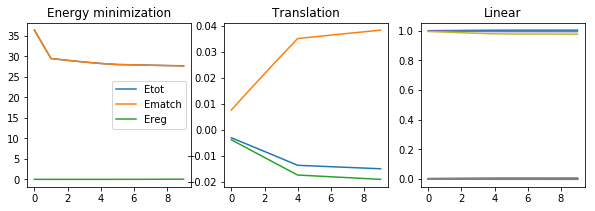

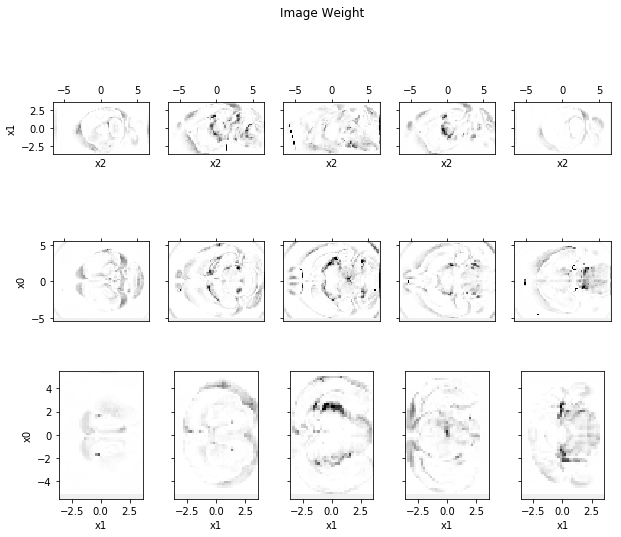

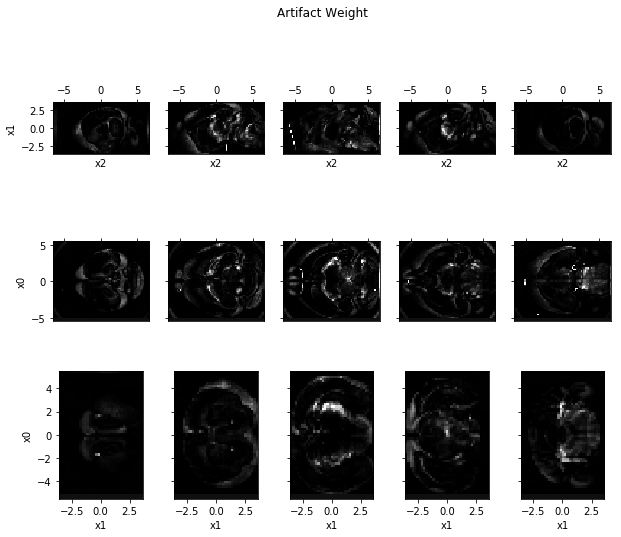

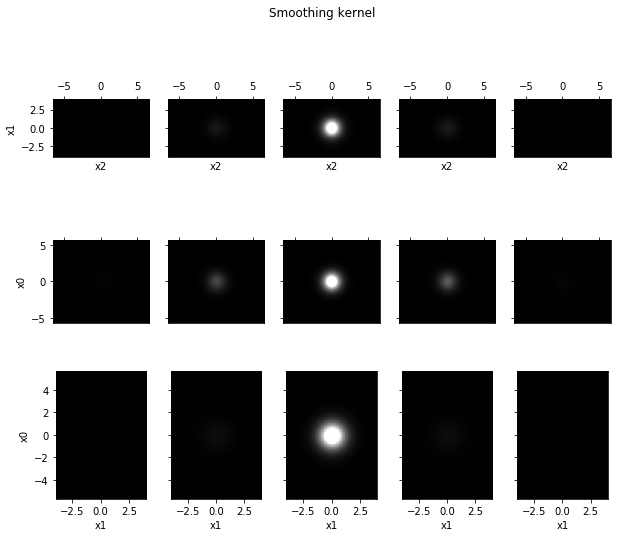

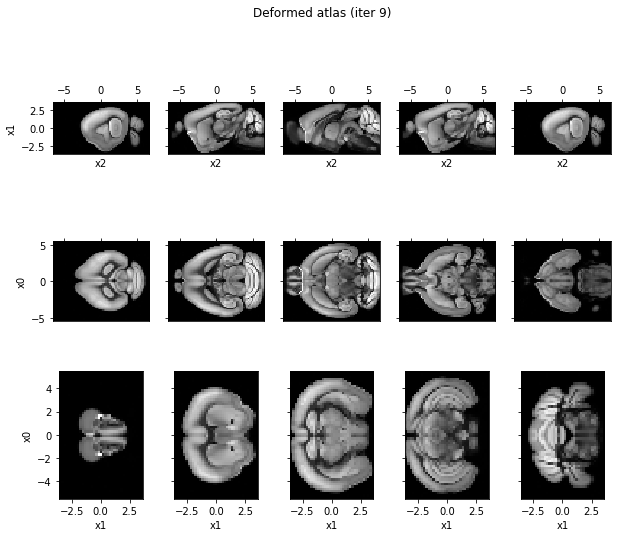

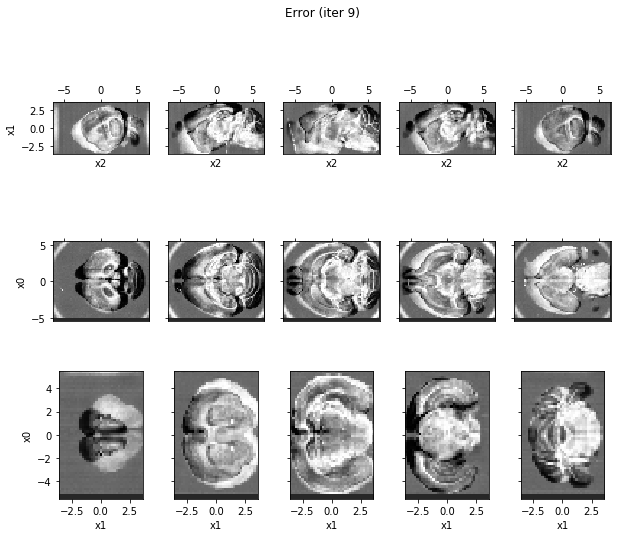

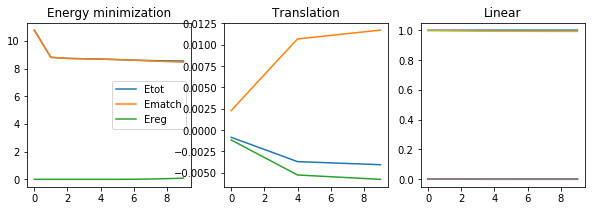

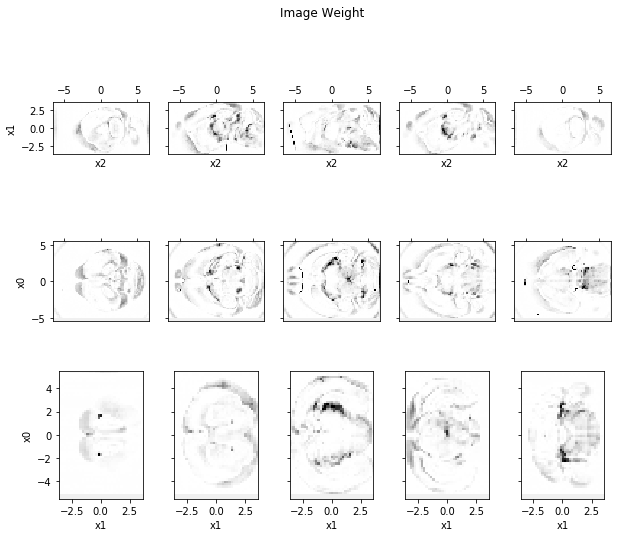

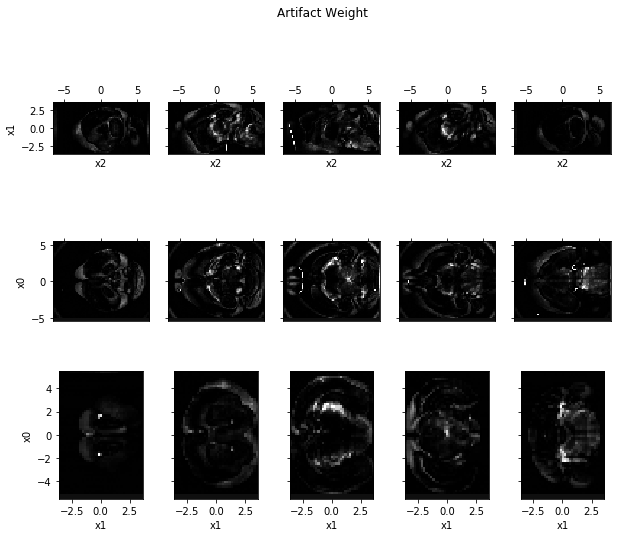

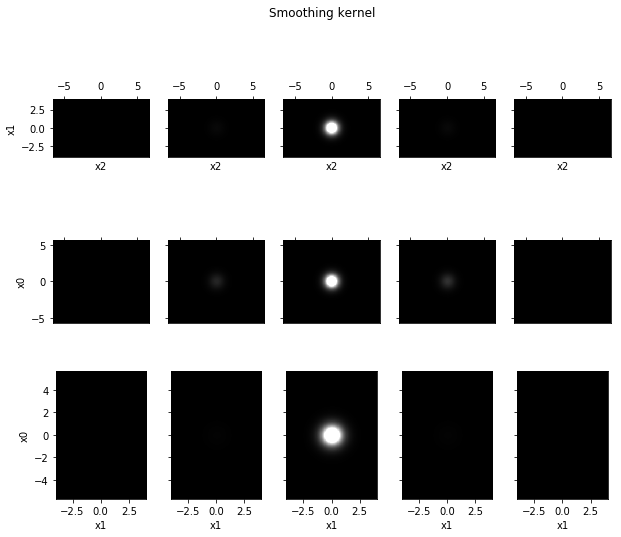

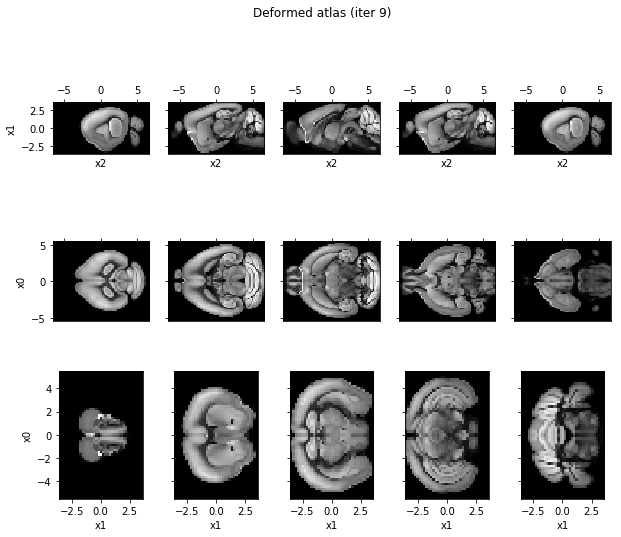

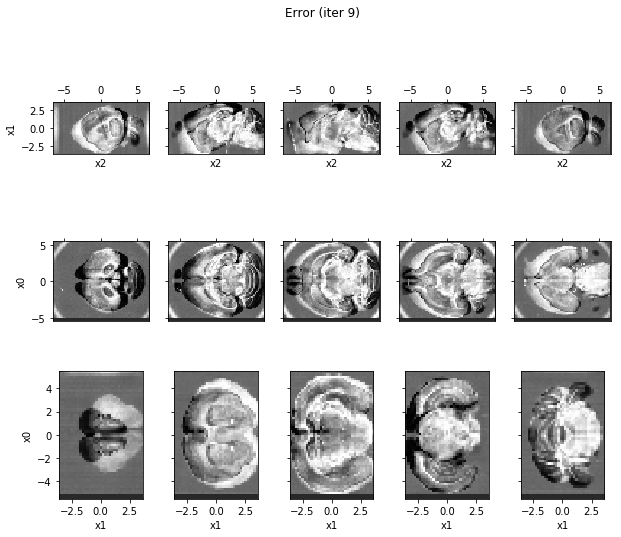

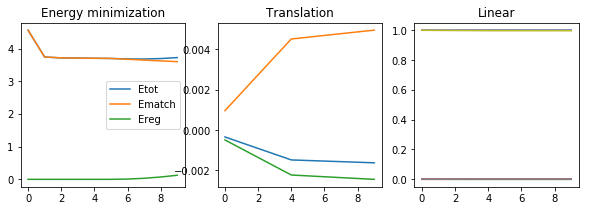

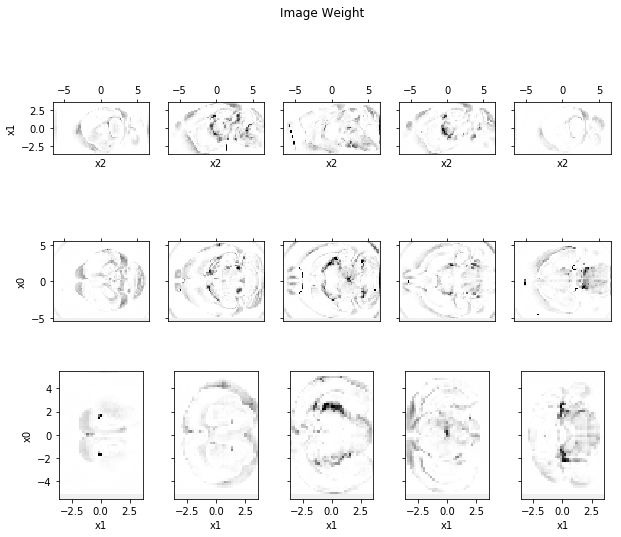

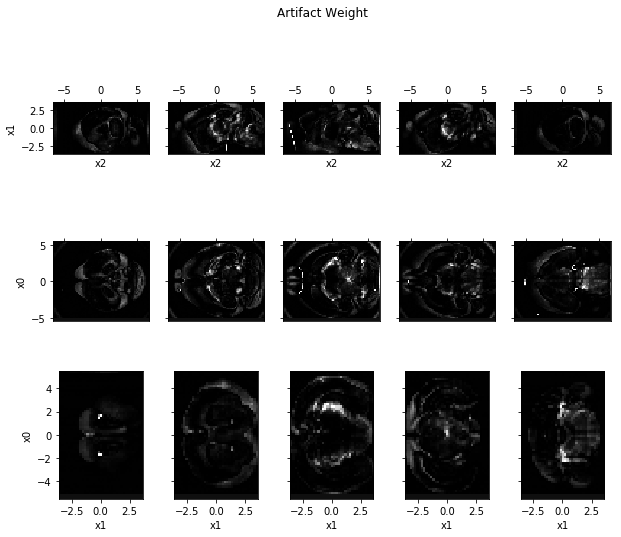

In [42]:
tmp_atlas = None
all_transforms = []
atlas_np = sitk.GetArrayViewFromImage(atlas)
for i,j in tqdm(enumerate(spacings)):
    # downsample the images
    img_ds = preprocessor.preprocess_brain(img, 
                                          j, 
                                          params['image_modality'],
                                          params['image_orientation'])
    # if it's the  first iteration no need to deform the atlas
    if tmp_atlas == None:
        atlas_ds = preprocessor.imgResample(atlas,j)
        atlas_registered, out = ndreg.register_brain(atlas_ds, img_p)
    else:
        atlas_registered, out = ndreg.register_brain(tmp_atlas, img_p)
        transformation_a2d = [out['phiinvAinv{}'.format(i)] for  i in range(3)]
        transformation_d2a = [out['Aphi{}'.format(i)] for  i in range(3)]
        
        if i < len(spacing):
            # if it's not the highest resolution
            # upsample the transformation
            transformation_a2d_upsampled = []
            for t in transformation_a2d:
                initial_positions = get_grid_locations(t,j)
                x = get_grid_locations(atlas_dsnp,spacings[i+1])
                new_positions = np.meshgrid(x[0],x[1],x[2],indexing='ij')
                transformation_a2d_upsampled.append(resample(t,initial_positions,new_positions))
            atlas_dsnp = sitk.GetArrayViewFromImage(preprocessor.imgResample(atlas,spacings[i+1]))
            atlas_t = resample(atlas_np,get_grid_locations(atlas_dsnp,spacings[i+1]),
                           transformation_a2d_upsampled)
            atlas_t = sitk.GetImageFromArray(atlas_t)
            atlas_t.SetSpacing(spacings[i+1])
            tmp_atlas = atlas_t
        else:
            transformation_a2d_upsampled = transformation_a2d
            # apply upsampled transformation to atlas
            atlas_dsnp = sitk.GetArrayViewFromImage(preprocessor.imgResample(atlas,spacings[-1]))
            atlas_t = resample(atlas_np,get_grid_locations(atlas_dsnp,spacings[-1]),
                           transformation_a2d_upsampled)
            atlas_t = sitk.GetImageFromArray(atlas_t)
            atlas_t.SetSpacing(spacings[-1])

In [128]:
# apply upsampled transformation to atlas
atlas_t = resample(atlas_dsnp,get_grid_locations(atlas_dsnp,spacings[1]),
                   transformation_a2d_upsampled)
atlas_t = sitk.GetImageFromArray(atlas_t)
atlas_t.SetSpacing(spacings[1])

(<Figure size 720x576 with 15 Axes>,
 [[<matplotlib.axes._subplots.AxesSubplot at 0x1761ac128>,
   <matplotlib.axes._subplots.AxesSubplot at 0x177db5ac8>]])

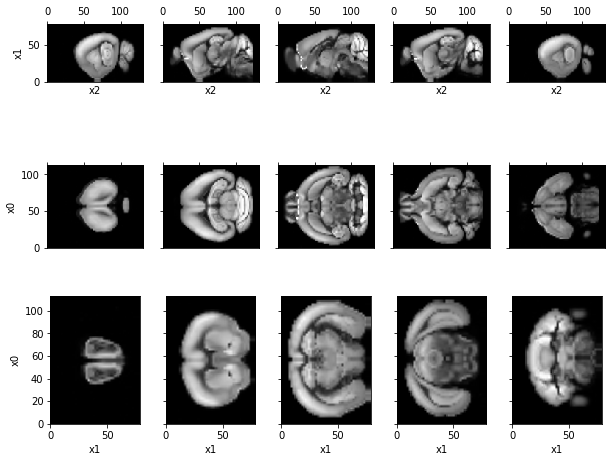

In [124]:
vis.imshow_slices(atlas_t)

Updating weights
Finished iteration 0, energy 2.186343e+02 (match 2.186343e+02, reg 0.000000e+00)
Updating weights
Finished iteration 1, energy 1.798151e+02 (match 1.798151e+02, reg 0.000000e+00)
Updating weights
Finished iteration 2, energy 1.781837e+02 (match 1.781837e+02, reg 0.000000e+00)
Updating weights
Finished iteration 3, energy 1.772179e+02 (match 1.772179e+02, reg 0.000000e+00)
Updating weights
Finished iteration 4, energy 1.760188e+02 (match 1.760188e+02, reg 0.000000e+00)
Updating weights
Finished iteration 5, energy 1.748933e+02 (match 1.748933e+02, reg 0.000000e+00)
Finished iteration 6, energy 1.744177e+02 (match 1.744156e+02, reg 2.074264e-03)
Finished iteration 7, energy 1.738987e+02 (match 1.738905e+02, reg 8.180743e-03)
Finished iteration 8, energy 1.733992e+02 (match 1.733811e+02, reg 1.812083e-02)
Finished iteration 9, energy 1.729189e+02 (match 1.728872e+02, reg 3.170381e-02)


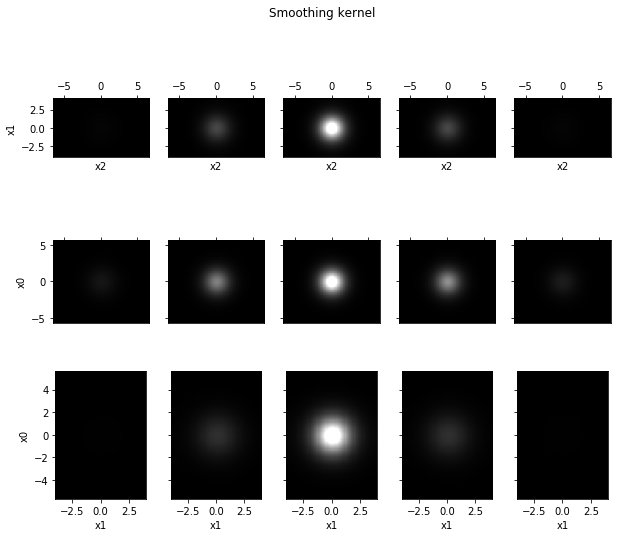

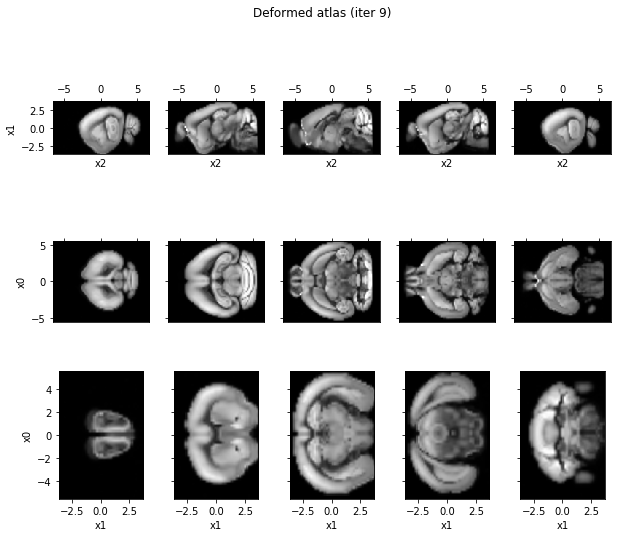

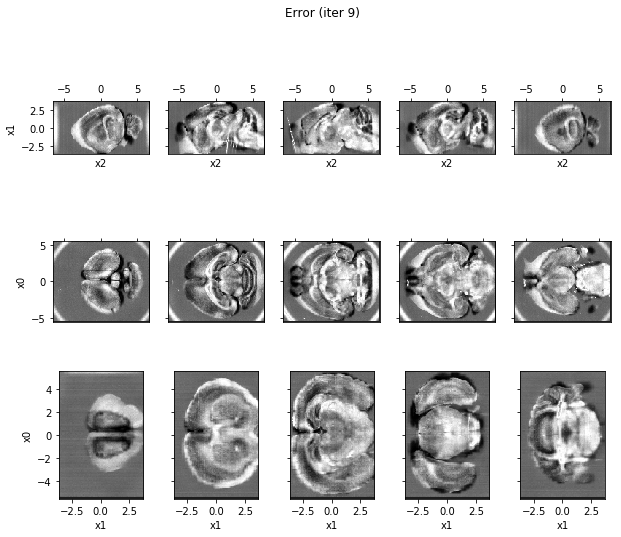

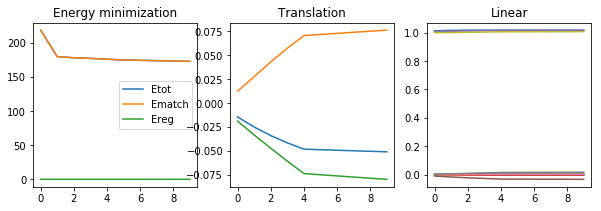

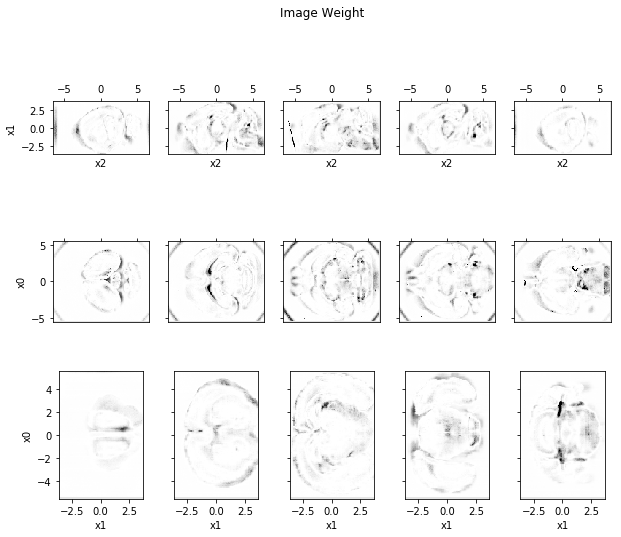

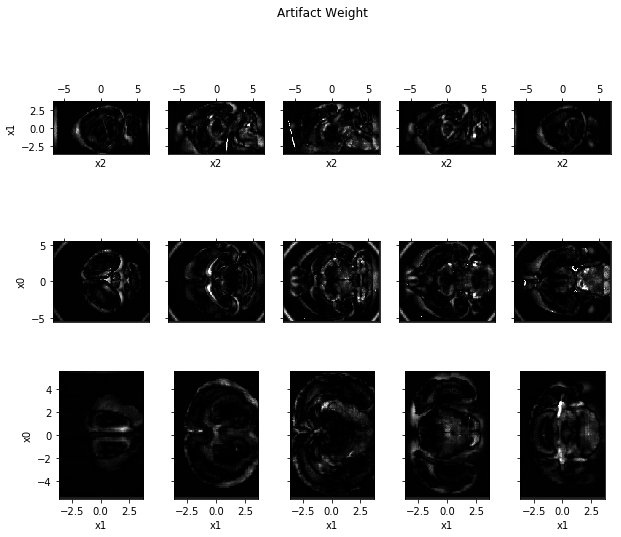

In [129]:
atlas_registered, out = ndreg.register_brain(atlas_t, img_ds)

In [ ]:
#trilinear interpolation on high res image
# these points correspond to my image
X0,X1,X2 = np.meshgrid(x[0],x[1],x[2],indexing='ij')
X0tf = tf.constant(X0,dtype=lddmm.dtype)
X1tf = tf.constant(X1,dtype=lddmm.dtype)
X2tf = tf.constant(X2,dtype=lddmm.dtype)
Itf = tf.constant(I,dtype=lddmm.dtype)

# these correspond to my transformation, let's assume it is lower res
# we will just downsample it as a quick hack here
phi0 = X0+10
phi1 = X1*1.2
phi2 = X2 + X2**2*0.005
# downsample transformation phi
down = 3
phi0 = phi0[::down,::down,::down]
phi1 = phi1[::down,::down,::down]
phi2 = phi2[::down,::down,::down]
# downsample grid X
xphi = [x[0][::down], x[1][::down], x[2][::down]]
Xphi0,Xphi1,Xphi2 = np.meshgrid(xphi[0],xphi[1],xphi[2],indexing='ij')
# tensors
phi0tf = tf.constant(phi0,dtype=lddmm.dtype)
phi1tf = tf.constant(phi1,dtype=lddmm.dtype)
phi2tf = tf.constant(phi2,dtype=lddmm.dtype)
Xphi0tf = tf.constant(Xphi0,dtype=lddmm.dtype)
Xphi1tf = tf.constant(Xphi1,dtype=lddmm.dtype)
Xphi2tf = tf.constant(Xphi2,dtype=lddmm.dtype)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # first we upsample the transformation
    
    phi0up = lddmm.interp3(xphi[0],xphi[1],xphi[2],phi0tf,X0tf,X1tf,X2tf)
    phi1up = lddmm.interp3(xphi[0],xphi[1],xphi[2],phi1tf,X0tf,X1tf,X2tf)
    phi2up = lddmm.interp3(xphi[0],xphi[1],xphi[2],phi2tf,X0tf,X1tf,X2tf)
    
    Id = lddmm.interp3(x[0],x[1],x[2],Itf,phi0up,phi1up,phi2up)
    Idnp = Id.eval()
f = plt.figure()
vis.imshow_slices(Idnp,x=x,fig=f)
f.suptitle('Example of transforming by linear interpolation')
f.canvas.draw()


## Visualize registered image

The two images below should match if the registration worked successfully!

(<Figure size 720x576 with 15 Axes>,
 [[<matplotlib.axes._subplots.AxesSubplot at 0x1549bb080>,
   <matplotlib.axes._subplots.AxesSubplot at 0x156abc320>]])

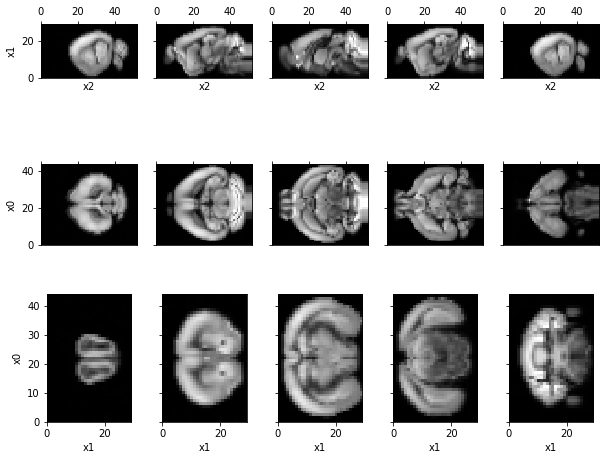

In [15]:
vis.imshow_slices(atlas_registered)

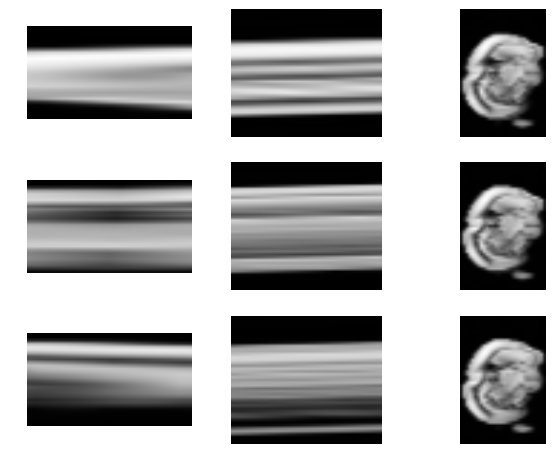

In [14]:
plotter.imgShow(sitk.GetImageFromArray(atlas_registered))

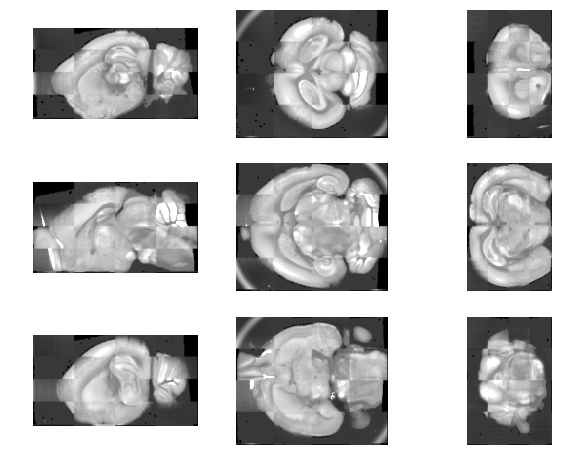

In [19]:
plotter.imgShow(plotter.imgChecker(atlas_registered, img_p), vmax=2)

# Quantitative evaluation

Here, we print out the Mean Squared Error between both the atlas and the observed data. As we can see, this metric decreases from the unprocessed data (first cell below this one) to the final atlas registered to our data (3rd cell below this one)

In [15]:
ndreg.imgMSE(sitk.Normalize(atlas), sitk.Normalize(img))

1.9355552516414318

In [16]:
ndreg.imgMSE(sitk.Normalize(atlas), sitk.Normalize(img_p))

0.7295863343639051

In [17]:
ndreg.imgMSE(sitk.Normalize(atlas_registered), sitk.Normalize(img_p))

0.416928609017568